## Image Segmentation Model

This notebook is an attempt to put into use what I've learned so far. The goal is the following: be able to prepare a dataset made of images, train a deep learning model with it and be able to use this model on new data to produce unsupervised results.
The model has to segment a given image and label each segment. Those images are aerial/satellite pictures and we want to automatically extract areas with recognizable structures like buildings, roads or vegetation on the pictures.

![satellite picture](./dataset/Tile%201/images/image_part_001.jpg) ![mask output](./dataset/Tile%201/masks/image_part_001.png)

### The dataset

In order to accomplish that, I need a dataset made of Earth pictures and a labeled mask for each of these pictures.
The "Semantic segmentation of aerial imagery" is an open dataset made of satellite images of Dubai and their mask couterpart that I will attempt to use for this project.

### The model

After looking for a model that take images as its input and its output in order to represent information over said images, the encoder-decoder architecture seems to be a good choice. Especially the U-Net model is made for this exact kind of applications. I will try to use this model for this project.

## Data Preprocessing

First, imports:

In [1]:
from pathlib import Path
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

First, we get the images and masks paths:

In [2]:
data_path = Path(".") / "dataset"

tiles = ["Tile " + str(i) for i in range(1, 9)]

images_root_paths = [Path(data_path) / tile / "images" for tile in tiles]
masks_root_paths = [Path(data_path) / tile / "masks" for tile in tiles]

image_extension = '.jpg'
mask_extension = '.png'

In [3]:
images_paths = []
for path in images_root_paths:
	images_paths += [Path(path) / image for image in os.listdir(path) if os.path.isfile(Path(path) / image) and image.endswith(image_extension)]

images_paths.sort()

masks_paths = []
for path in masks_root_paths:
	masks_paths += [Path(path) / mask for mask in os.listdir(path) if os.path.isfile(Path(path) / mask) and mask.endswith(mask_extension)]

masks_paths.sort()

assert len(images_paths) == len(masks_paths) , "Not the same amount of images and masks paths."

print(f"{len(images_paths)} elements in dataset.")

72 elements in dataset.


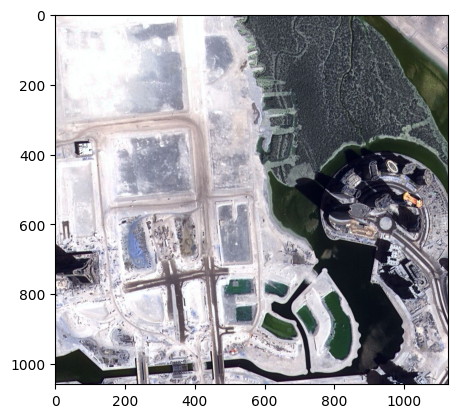

In [4]:
# Quick check to see if it's ok.
with Image.open(images_paths[42]) as img:
	plt.imshow(img)

I now have all the paths for the images and masks from the dataset.
Let's now prepare those. The first step is to split the shape of our images to standardize the input our model will take. We'll use the patchify library.
After documenting, I shall choose a patch size which is a 32 multiple. 128, 256 and 512 appear to be the most common choices.

In [5]:
patch_size = 256

(4, 4, 1, 256, 256, 3)


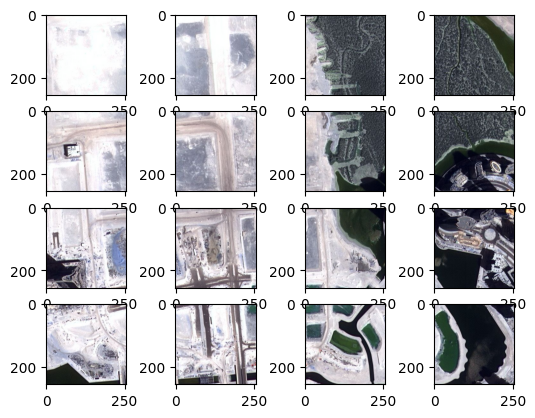

In [6]:
from patchify import patchify

with Image.open(images_paths[42]) as img:
	img = np.array(img)
	patches = patchify(img, patch_size=(patch_size, patch_size, 3), step=patch_size)

	print(patches.shape)

	f, ax = plt.subplots(len(patches), len(patches[0]))
	i = 0
	for patch_x in patches:
		j = 0
		for patch_y in patch_x:
			ax[i, j].imshow(patch_y[0])
			j += 1
		i += 1

In [7]:
# In case flattening the patch list is needed later...
print(patches.shape)
patches_flat = patches.reshape(len(patches) * len(patches[0]) * len(patches[0][0]), patch_size, patch_size, 3)
print(patches_flat.shape)

(4, 4, 1, 256, 256, 3)
(16, 256, 256, 3)


Let's patchify all our data:

In [8]:
patched_images = []
for path in images_paths:
	image = Image.open(path)

	if (image.mode != 'RGB'):
		image = image.convert('RGB')

	image_arr = np.array(image)

	# Drop the image if it cannot be patched
	if (image_arr.shape[0] < patch_size or image_arr.shape[1] < patch_size):
		continue

	patches = patchify(image_arr, patch_size=(patch_size, patch_size, 3), step=patch_size)

	for patch_x in patches:
		for patch_y in patch_x:
			for patch in patch_y:
				patched_images.append(patch)

patched_masks = []
for path in masks_paths:
	mask = Image.open(path)

	if (mask.mode != 'RGB'):
		mask = mask.convert('RGB')

	mask_arr = np.array(mask)

	# Drop the mask if it cannot be patched
	if (mask_arr.shape[0] < patch_size or mask_arr.shape[1] < patch_size):
		continue

	patches = patchify(mask_arr, patch_size=(patch_size, patch_size, 3), step=patch_size)

	for patch_x in patches:
		for patch_y in patch_x:
			for patch in patch_y:
				patched_masks.append(patch)


assert len(patched_images) == len(patched_masks), "Not the same amount of patches for images and masks."
print(f"Total number of elements: {len(patched_images)}")

Total number of elements: 1305


We now have our data with the correct shape! We need to normalize it now.

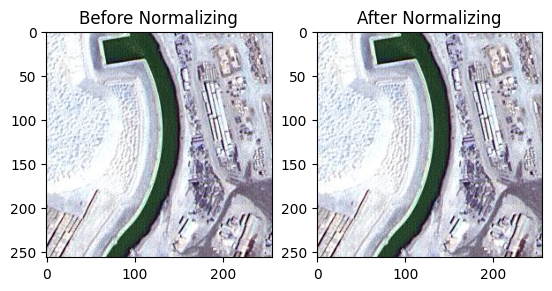

Just checking if the image remains the same before/after.
Number of normalized images = 1305


In [9]:
normalized_images = [(image / 255.0) for image in patched_images]

fig, ax_arr = plt.subplots(1, 2)
ax_arr[0].imshow(patched_images[0])
ax_arr[0].set_title("Before Normalizing")
ax_arr[1].imshow(normalized_images[0])
ax_arr[1].set_title("After Normalizing")
plt.show()

print("Just checking if the image remains the same before/after.")

assert len(normalized_images) == len(patched_masks), "Not the same amount of data before than after normalization."
assert np.array(normalized_images).shape == np.array(patched_masks).shape, "Normalized images and patched masks not of the same shape."

print(f"Number of normalized images = {len(normalized_images)}")

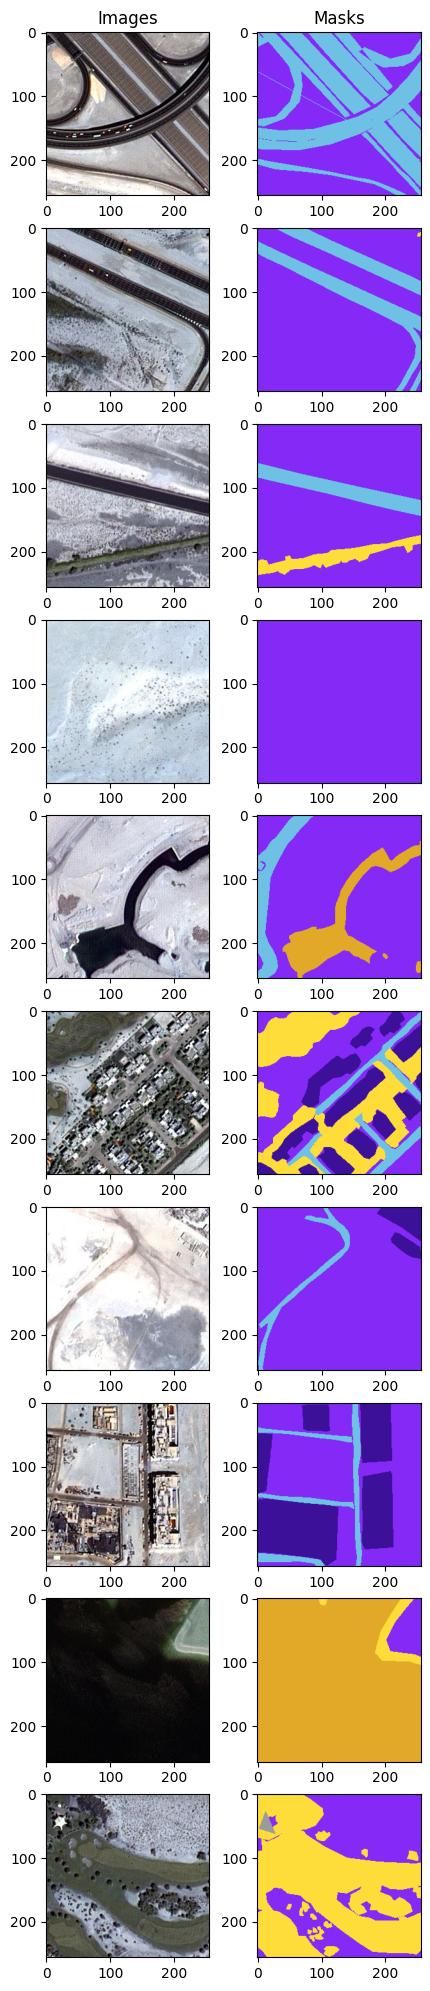

In [10]:
import random

fig, ax_arr = plt.subplots(10, 2, figsize=(5, 25))
ax_arr[0, 0].set_title("Images")
ax_arr[0, 1].set_title("Masks")

for i in range (0, 10):
	index = random.randint(0, len(normalized_images) - 1)
	ax_arr[i, 0].imshow(normalized_images[index])
	ax_arr[i, 1].imshow(patched_masks[index])

Our raw data should now be pretty much ready. Masks should probably not be normalized as they represent categorical value on an image.
Now we will process the categorical values for the segments.
We first create a dictionary containing all our labels' index and colors in RGB format. It will help encode our labels as well as probably decode future prediction made by the model.

In [16]:
# Manually getting those from the 'classes.json' file because there's no formatting convention on it:

classes = dict() # {key: (index, hex_color)

classes['Water'] = dict({'index': 0, 'color': 'E2A929'})
classes['Land'] = dict({'index': 1, 'color': '8429F6'})
classes['Road'] = dict({'index': 2, 'color': '6EC1E4'})
classes['Building'] = dict({'index': 3, 'color': '3C1098'})
classes['Vegetation'] = dict({'index': 4, 'color': 'FEDD3A'})
classes['Unlabeled'] = dict({'index': 5, 'color': '9B9B9B'})

# Convert hex to RGB:
for key in classes:
	color = classes[key]['color']
	color = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
	classes[key]['color'] = color

print(classes)

{'Water': {'index': 0, 'color': (226, 169, 41)}, 'Land': {'index': 1, 'color': (132, 41, 246)}, 'Road': {'index': 2, 'color': (110, 193, 228)}, 'Building': {'index': 3, 'color': (60, 16, 152)}, 'Vegetation': {'index': 4, 'color': (254, 221, 58)}, 'Unlabeled': {'index': 5, 'color': (155, 155, 155)}}


Then we create a function to convert each mask to a one-hot encoded label:

In [17]:
def rgb_to_class(mask: np.array) -> np.array:
	label_shape = (mask.shape[0], mask.shape[1], len(classes))
	label = np.zeros(shape=label_shape, dtype=np.float32)

	for key in classes:
		color = classes[key]['color']
		index = classes[key]['index']

		label[np.all(mask == color, axis=-1), index] = 1.0

	if (np.sum(label) != patch_size ** 2):	# Unknown color class
		unlabeled_index = classes['Unlabeled']['index']
		for col in label:
			for item in col:
				if np.sum(item) == 0:
					item[unlabeled_index] = 1

	assert np.sum(label) == patch_size ** 2, "Unknown color class."
	
	return label

We create the whole label dataset:

In [19]:
labels = [rgb_to_class(mask) for mask in patched_masks]

assert len(labels) == len(patched_masks), "Error encoding masks to labels."

print(f"Number of labels = {len(labels)}")

Number of labels = 1305


Now that we have both our preprocessed input images and our labelled output masks, we split the datasets into training and validation sets.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.asarray(normalized_images), np.asarray(labels), test_size=0.2, random_state=42)

We may augment the training dataset by flipping vertically some of the images/label mask pair:

(1577, 256, 256, 3)
(1577, 256, 256, 6)
(261, 256, 256, 3)
(261, 256, 256, 6)


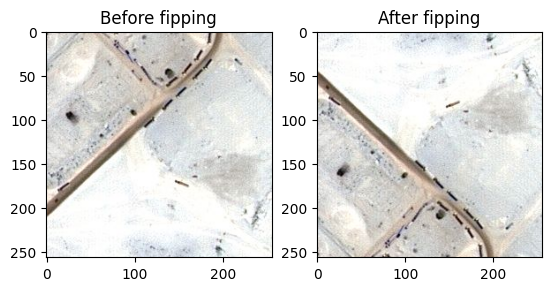

In [15]:

X_train_augmented = X_train
y_train_augmented = y_train
for i in range(0, len(X_train)):
	if (random.random() > 0.5):
		X_train_augmented = np.append(X_train_augmented, [np.flipud(X_train[i])], axis=0)
		y_train_augmented = np.append(y_train_augmented, [np.flipud(y_train[i])], axis=0)

assert len(X_train_augmented) == len(y_train_augmented) and len(X_test) == len(y_test), "Discrepency in the amount of data in training datasets or testing datasets."

fig, ax_arr = plt.subplots(1, 2)
ax_arr[0].imshow(X_train[42])
ax_arr[0].set_title("Before fipping")
ax_arr[1].imshow(np.flipud(X_train[42]))
ax_arr[1].set_title("After fipping")

print(X_train_augmented.shape)
print(y_train_augmented.shape)
print(X_test.shape)
print(y_test.shape)

We can now check that training and testing sets have the right dimensions!
Data preprocessing is done, we must now implement a model.

## Model creation, training and evaluation
For training purposes I will use keras.
I will be implementing the following U-Net architecture, as described in this [publication](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/).
![U-Net architecture](assets/u-net-architecture.png)

They evaluate the performance using an IoU matrix (Intersect over Union), I will use the same metric to evaluate my own.

In [20]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, CenterCrop
from keras import backend

2023-10-22 10:51:13.187442: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 10:51:13.612942: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 10:51:13.613087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 10:51:13.613278: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 10:51:14.056059: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 10:51:14.059600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [21]:
def iou_evaluate(y_true, y_pred):
	y_true_flat = backend.flatten(y_true)
	y_pred_flat = backend.flatten(y_pred)
	
	inter = backend.sum(y_true_flat * y_pred_flat)
	union = backend.sum(y_true_flat) + backend.sum(y_pred_flat) - inter
	
	return (inter + 1.0) / (union + 1.0)

Now defining the model:

In [32]:
def unet_model(num_classes, image_height, image_width, image_channels):
	
	input = Input(shape=(image_height, image_width, image_channels))
	
	source = input

	# May test Conv2D with kernel_initializer="he_normal" and/or padding="same"

	# 2 convolution with 3x3 kernel and relu activation + dropout
	conv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(source)
	conv1 = Dropout(0.2)(conv1)
	conv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(conv1)

	# 2x2 Pooling
	pool1 = MaxPooling2D((2, 2))(conv1)

	conv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(pool1)
	conv2 = Dropout(0.2)(conv2)
	conv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv2)

	pool2 = MaxPooling2D((2, 2))(conv2)

	conv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(pool2)
	conv3 = Dropout(0.2)(conv3)
	conv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv3)

	pool3 = MaxPooling2D((2, 2))(conv3)

	conv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool3)
	conv4 = Dropout(0.2)(conv4)
	conv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv4)

	pool4 = MaxPooling2D((2, 2))(conv4)

	conv5 = Conv2D(256, (3, 3), activation="relu", padding="same")(pool4)
	conv5 = Dropout(0.2)(conv5)
	conv5 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv5)

	# 2x2 Up convolution
	upconv6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv5)

	# Skipping layer: crop + concatenate
	# size6 = upconv6.shape[1]
	# crop4 = CenterCrop(height=size6, width=size6)(conv4)
	upconv6 = concatenate([upconv6, conv4])

	# 2 convolution with 3x3 kernel and relu activation + dropout layer
	upconv6 = Conv2D(128, (3, 3), activation="relu", padding="same")(upconv6)
	upconv6 = Dropout(0.2)(upconv6)
	upconv6 = Conv2D(128, (3, 3), activation="relu", padding="same")(upconv6)

	upconv7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(upconv6)

	# size7 = upconv7.shape[1]
	# crop3 = CenterCrop(height=size7, width=size7)(conv3)
	upconv7 = concatenate([upconv7, conv3])

	upconv7 = Conv2D(64, (3, 3), activation="relu", padding="same")(upconv7)
	upconv7 = Dropout(0.2)(upconv7)
	upconv7 = Conv2D(64, (3, 3), activation="relu", padding="same")(upconv7)

	upconv8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(upconv7)

	# size8 = upconv8.shape[1]
	# crop2 = CenterCrop(height=size8, width=size8)(conv2)
	upconv8 = concatenate([upconv8, conv2])

	upconv8 = Conv2D(32, (3, 3), activation="relu", padding="same")(upconv8)
	upconv8 = Dropout(0.2)(upconv8)
	upconv8 = Conv2D(32, (3, 3), activation="relu", padding="same")(upconv8)

	upconv9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(upconv8)

	# size9 = upconv9.shape[1]
	# crop1 = CenterCrop(height=size9, width=size9)(conv1)
	upconv9 = concatenate([upconv9, conv1])

	upconv9 = Conv2D(16, (3, 3), activation="relu", padding="same")(upconv9)
	upconv9 = Dropout(0.2)(upconv9)
	upconv9 = Conv2D(16, (3, 3), activation="relu", padding="same")(upconv9)

	# Final softmax activation for classification
	output = Conv2D(num_classes, (1, 1), activation="softmax")(upconv9)

	unet_model = Model(inputs=[input], outputs=[output])
	return unet_model

I've added dropout to avoid overfitting with a rate of 0.2, as suggested in this [article](https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9) (CNN may show better results with Batch Normalization instead).

In [33]:
num_classes = len(classes)
unet = unet_model(num_classes=num_classes, image_height=patch_size, image_width=patch_size, image_channels=3)

Lastly, we need a loss function before training the model. In the paper, they use cross entropy. After documenting, many people seem to use an augmented version of it combining categorical cross entropy and dice loss. Dice loss is one of the most common loss function in segmentation problems as it focuses on accuracy of the segmentations' limit.

In [24]:
def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    inputs = backend.flatten(inputs)
    targets = backend.flatten(targets)
    
    bce =  backend.categorical_crossentropy(targets, inputs)
    intersection = backend.sum(backend.dot(targets, inputs))
    dice_loss = 1 - (2*intersection + smooth) / (backend.sum(targets) + backend.sum(inputs) + smooth)
    dice_bce = bce + dice_loss
    
    return dice_bce

Let's now compile our model:

In [25]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [28]:
# We use adam optimizer as described here https://arxiv.org/pdf/2007.02839.pdf
unet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", iou_evaluate])

In [29]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 254, 254, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 254, 254, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 252, 252, 16)         2320      ['dropout[0][0]']             
                                                                                              

Now we train our model:

In [34]:
training_history = unet.fit(X_train, y_train, batch_size=16, verbose=True, epochs=10, validation_data=(X_test, y_test), shuffle=False)

TypeError: Model.fit_generator() got an unexpected keyword argument 'batch_size'